<a href="https://colab.research.google.com/github/dvrg/Topic-Modeling-Trending-News-Indonesia/blob/master/Topic_Modeling_Pada_Tweets_Kompas_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author : David Rigan

Publish : Mei 2019

Pertama-tama, kita perlu import tersebut dahulu beberapa library yang akan berguna pada pekerjaan kita kali ini. **matplotlib** digunakan untuk visualisasi seperti gambar di atas. Adapun tools untuk implementasi LDA yang akan kita gunakan adalah gensim. Menurut pengalaman saya pribadi, gensim memberikan fungsionalitas yang baik dalam hal API dan efisiensi komputasi. Selain itu, **nltk** digunakan untuk preprocessing seperti proses stopword removal, tokenization, dan stemming; kemudian, **scikit-learn** digunakan untuk proses clustering dokumen tweet, serta reduksi dimensi dari vektor tweet agar bisa di-plot ke bidang 2-dimensi. 

In [ ]:
!pip install Sastrawi
!pip install tweepy

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import gensim
import nltk

from nltk.stem.snowball import SnowballStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from gensim.corpora import Dictionary, MmCorpus
from gensim.models import ldamodel

from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

Kemudian, kita akan membuat terlebih dahulu fungsi untuk memuat/load dataset kita yang berupa kumpulan twitter account name beserta tweet yang di-post.

In [ ]:
def load_dataset(filename):
    file = open(filename, 'r')
    
    acc_names = []
    tweets = []
    
    for line in file:
        line = line.strip()
        parts = line.split('###')
        acc_names.append(parts[0])
        tweets.append(parts[1])
        
    return acc_names, tweets

Hyper-parameter yang perlu kita tentukan pertama kali adalah "banyaknya topik" yang akan ditemukan oleh LDA. Di satu sisi, ini sepertinya adalah kelemahan vanilla LDA karena tidak bisa menentukan banyaknya topik secara otomatis. Namun, saat ini, sudah ada banyak varian dari LDA yang mampu menentukan topik secara otomatis, termasuk salah satunya adalah Hierachical Dirichlet Process (HDP) [1], dan gensim juga punya implementasi dari HDP ! 

In [ ]:
# config_var
num_topics=4

Berikutnya adalah kita perlu hidupkan beberapa objek untuk pra-pemrosesan seperti lowercasing, stopword removal, dan stemming. Kita perlu melakukan stopword removal karena kita tentunya tidak ingin jenis kata tersebut menjadi wakil dari salah satu topik yang diakibatkan tingginya frekuensi dari stopword. Kata-kata topik biasanya adalah content word yang mayoritas merupakan kata benda dan kata kerja. 

In [ ]:
# definisikan beberapa fungsi untuk kebutuhkan pre-processing, pre-processing yang dilakukan adalah
# 1. lowercasing
# 2. stopword removal
# 3. stemming

#stemmer = SnowballStemmer("english") # indonesia

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#stopwords = nltk.corpus.stopwords.words('english')
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

def preprocess(text):
    # tokenize and lowercasing
    tokens = [word.lower() for word in text.split()]
    filtered_tokens = []
    
    #buat yang bukan terdiri dari alfabet, dan merupakan stopword
    for token in tokens:
        if re.search('[a-zA-Z]', token) and (token not in stopwords):
            filtered_tokens.append(token)
            
    # lakukan steming dengan snowball stemmer
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

Lalu, kita muat/load dataset kita dengan fungsi yang sudah kita bangun sebelumnya, dan kenakan pre-processing terhadap dataset kita yang sudah dimuat tersebut. 

In [ ]:


# kita load dokumen twitter dan lakukan preprocessing terhadap tweet yang sudah di load
acc_names, tweets = load_dataset("tweet-kompas.txt")

# lakukan preprocessing untuk setiap tweet pada koleksi "tweets" kita
# Gunakan List Comprehension untuk mempermudah hidup kita
tweets = [preprocess(tweet) for tweet in tweets]

Setelah itu, kita buat dictionary dari semua kata-kata dalam koleksi dokumen kita. Intinya adalah kita lakukan indexing untuk semua kata-kata yang ada pada koleksi dokumen kita (yang ingin dicari distribusi topik-nya). Perlu diingat bahwa LDA menganggap sebuah dokumen sebagai bag-of-words (BoW) karena informasi urutan antar kata dalam dokumen tidak diperlukan. 

In [ ]:


# membuat term dictionary dari korpus kita, dimana setiap kata unik akan diberikan sebuah index
dictionary = Dictionary(tweets)

# hapus term yang:
# 1. muncul di kurang dari 2 dokumen
# 2. muncul di lebih dari 0.9*(total_dok) dokumen
dictionary.filter_extremes(no_below=2, no_above=0.9)

# ubah dictionary menjadi object bag-of-words references
# ingat bahwa LDA, dokumen dasumsikan dengan bag-of-words model
corpus = [dictionary.doc2bow(tweet) for tweet in tweets]

Sekarang, saatnya kita jalankan LDA untuk infer distribusi topik secara otomatis! Untuk melakukan estimasi, gesim LDA menggunakan metode Variational Bayes (bukan dengan Gibbs Sampling). Proses yang dijalankan mendukung online learning berdasarkan algoritma oleh M. Hoffman [2], dimana kita bisa update parameter secara langsung ketika ada dokumen baru. Perhatikan bahwa bagian ini dapat memakan waktu lama tergantung iterasi yang di-set. 

In [ ]:
# Jalankan LDA
lda = ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=1, iterations=5000)

Setelah itu, kita bisa coba lihat-lihat topik-topik yang berhasil di-infer oleh LDA beserta kata-kata wakil dan distribusinya. 

In [ ]:
# tampilkan topic matrix
topics_matrix = lda.show_topics(formatted=False)

for topic_no, topic_words in topics_matrix:
    print('topic number: {}'.format(topic_no))
    
    # default: top 1- kata yang paling tinggi probabilitasnya
    for word, prob in topic_words:
        print(word, prob)

topic number: 0
tahun 0.6684913
timur 0.08402026
empat 0.08321981
tulungagung 0.0827454
jawa 0.08152317
topic number: 1
tahun 0.3793761
empat 0.37798214
jawa 0.08198442
timur 0.080346346
tulungagung 0.08031098
topic number: 2
jawa 0.35503247
timur 0.35458353
tulungagung 0.19872493
tahun 0.048645362
empat 0.04301371
topic number: 3
tulungagung 0.3758775
empat 0.37241104
tahun 0.090969115
timur 0.0803885
jawa 0.08035383


## Pengelompokan Dokumen (clustering)

Setelah kita berhasil infer distribusi topik untuk koleksi dan juga masing-masing dokumen tweet, sekarang kita coba cluster tweet berdasarkan kedekatan topik. Sebuah dokumen/tweet direpresentasikan sebagai vektor yang setiap cell-nya merupakan probabilitas topik tertentu terkait dokumen tersebut.

In [ ]:
# bentuk terlebih dahulu vektor dokumen/tweets
# vektor tweet/dokumen = vektor probabilitas terhadap masing-masing topik

tweet_vectors = []
for tweet in tweets:
    probs = [prob for (_,prob) in lda.get_document_topics(dictionary.doc2bow(tweet))]
    tweet_vectors.append(probs)
tweet_vectors = np.array(tweet_vectors)

# set banyaknya cluster = banyaknya topik
num_clusters = num_topics

# gunakan algoritma K-Means, dan lakukan clustering
km = KMeans(n_clusters=num_clusters)
km.fit(tweet_vectors)

# jka kita ingin melihat indeks cluster untuk setiap tweet/dokumen
clusters =km.labels_.tolist()

print(clusters)

[0, 0, 2, 0, 0, 2, 3, 1, 1]


### Penentuan Wakil Kata untuk Topik Utama di Setiap Cluster

Sebelumnya, kita mengasumsikan bahwa dokumen-dokumen atau kumpulan tweet yang berada dalam satu cluster adalah yang kira-kira membicarakan topik-topik yang sama karena distribusi topik-nya dekat. Sekarang, kita ingin memberi label untuk setiap cluster agar kira-kira topik-topik utama apa yang dibicarakan di setiap cluster. Cara yang paling mudah untuk memberi nama topik yang major adalah dengan melihat vektor centroid dari masing-masing cluster. Lalu, untuk setiap centroid, kita lihat siapa topik yang probabilitas-nya atau proporsi-nya paling tinggi. Nah, kira-kira kata-kata dari topik yang probabilitas paling tinggi itulah yang menjadi wakil dari cluster yang bersesuaian. 

In [ ]:
# untuk setiap cluster center, kita sort argumen/index berdasarkan nilai probabilitasnya
# karena index/argumen adalah id topik.
#
# jadi, secara intuisi, ini adalah cara untuk mencari topik major yang dibicarakan di sebuah cluster
# nantinya, wakil kata cluster akan diambil dari 2 topik major di setiap cluster
#
# ::-1 artinya reverse list

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

cluster_names = {}
for i in range(num_clusters):
    print("cluster %d words:" % i)
    
    # ambil 2 topik major untuk setiap cluster
    topic_words = []
    for ind in order_centroids[i, :1]:
        topic_words += [dictionary.get(word_id) for (word_id, prob) in lda.get_topic_terms(ind, topn=2)]
        
    cluster_names[i] = ','.join(topic_words)
    
    print(cluster_names[i])

cluster 0 words:
tahun,empat
cluster 1 words:
jawa,timur
cluster 2 words:
tahun,timur
cluster 3 words:
tulungagung,empat


### Visualisasi Cluster dengan Matplotlib

Agar bisa di-plot ke bidang 2-dimensi, kita perlu reduksi dimensi vektor dokumen yang awalnya sebanyak #topik menjadi 2-dimensi. Kita dapat menggunakan berbagai macam teknik seperti Multidimensional Scaling (MDS) atau Princiap Component Analysis (PCA) (pilih salah satu). 

In [ ]:
### plot ke 2D ###

# reduksi dimensi dengan multidimensional scaling
mds = MDS(n_components=2)
pos = mds.fit_transform(tweet_vectors) # shape (n_components, n_samples)

#pca = PCA(n_components=2)
#pos = pca.fit_transform(tweet_vectors) # shape (n_components, n_samples)

# ambil hasil reduksi ke 2D untuk posisi x dan y --> agar bis di plot ke bidang kartesisus
xs, ys  = pos[:, 0], pos[:, 1]

Setelah itu, kita buat beberapa fungsi untuk plotting beberapa informasi yang kita butuhkan ke bidang kartesius. 

In [ ]:
# fungsi yang digunakan untuk plot cluster dokumen berdsarkan distribusi topik yang dimilikinya
# xs adalah posisi axis dari semua dokumen (numpy list of real number)
# ys adalah posisi ordinat dari semua dokumen (numpy list of real number)
# clusters adalah list dari cluster index untuk masing-masing dokumen
# acc_names adalah list dari nama-nama dokumen (dalam hal ini, nama-nama akun tweet)
def plot_doc_cluster(xs, ys, clusters, acc_names):
    # warna cluster - maksimal 5 cluster
    cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

    # gunakan Pandas untuk kemudahan proses data, terutama untuk grouping
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, acc_names=acc_names))
    groups = df.groupby('label') #group by cluster!!!

    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05)

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point

    for i in range(len(df)):
        ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['acc_names'], size=8)

    plt.show()

# fungsi yang digunakan untuk plot distribusi kata per-topik yang ditemukan
def plot_word_dist_per_topic(topic_no, topics_matrix, width=0.5):
    _, topic_words = topics_matrix[topic_no]

    # hanya top-10 yang paling tinggi probabilitasnya
    words = []
    probs = []
    for word, prob in topic_words:
        words.append(word)
        probs.append(prob)

    ind = np.arange(len(words))

    plt.bar(ind, probs, width=width)
    plt.xticks(ind + width/2, words, rotation='vertical')
    plt.title('Word Distribution of Topic {}'.format(topic_no))
    plt.show()

Sekarang, kita coba plot dengan fungsi yang pertama untuk menghasilkan gambar seperti yang di atas. 

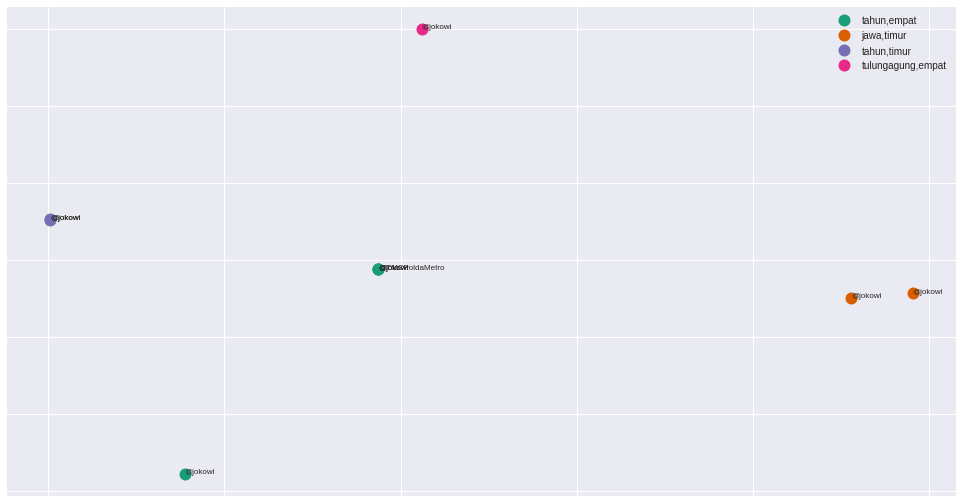

In [ ]:
# plot cluster dokumen/tweet
plot_doc_cluster(xs, ys, clusters, acc_names)

Kemudian, fungsi plotting yang kedua digunakan untuk melihat Top-10 Kata paling probable atau yang paling besar proporsinya untuk topik tertentu. 

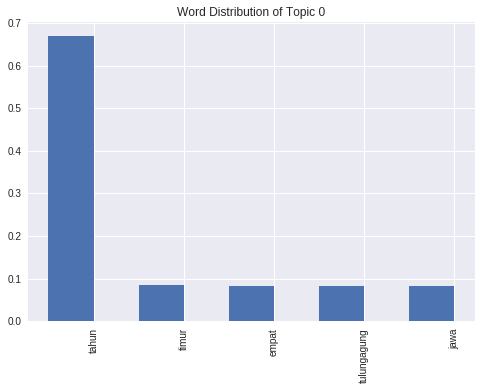

In [ ]:
# plot word distribution untuk topic 0
plot_word_dist_per_topic(0, topics_matrix)

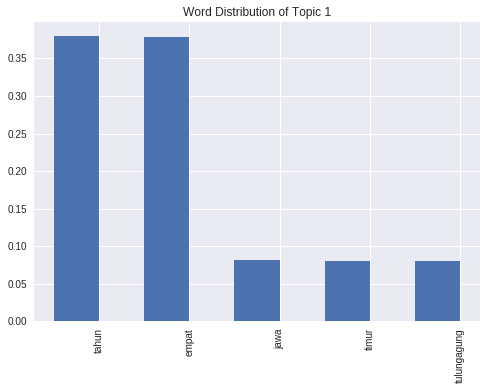

In [ ]:
# plot word distribution untuk topic 1
plot_word_dist_per_topic(1, topics_matrix)

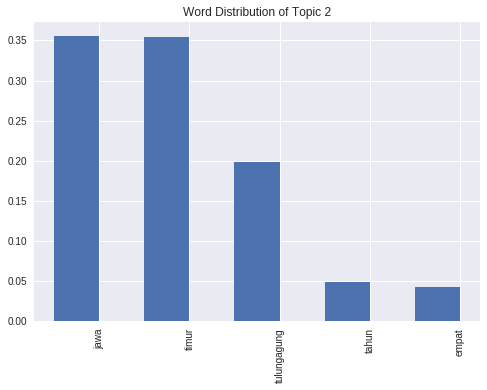

In [ ]:
# plot word distribution untuk topic 2
plot_word_dist_per_topic(2, topics_matrix)

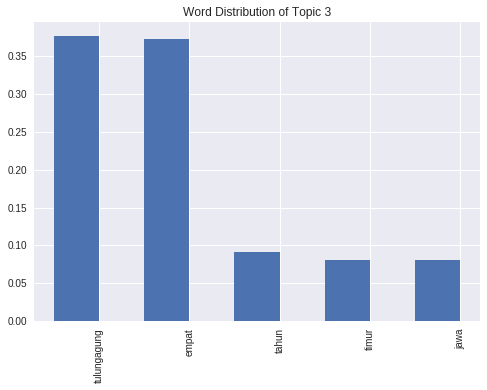

In [ ]:
# plot word distribution untuk topic 3
plot_word_dist_per_topic(3, topics_matrix)